# 第31章: 最尤推定と生成モデルの基礎

## 📋 この章で学ぶこと

この章を終えると、以下ができるようになります：

- [ ] 生成モデルの概念を理解できる
- [ ] 母集団とサンプルの違いを説明できる
- [ ] 最尤推定の理論を理解できる
- [ ] 正規分布のパラメータを推定できる
- [ ] 生成モデルで新しいデータを生成できる

## 🎯 前提知識

この章を学ぶには以下の知識が必要です：

- ✅ Notebook 30（正規分布と確率の基礎）
- ✅ 基礎的な微分の知識

⏱️ **推定学習時間**: 120-150分  
📊 **難易度**: ★★★☆☆（中級）  
🎓 **カテゴリ**: 基礎

---

## 🌟 はじめに

前章では正規分布について学びました。この章では、**データから確率分布のパラメータを推定する方法**と、**生成モデル**の基礎を学びます。

### 🤔 生成モデルとは？

**生成モデル（Generative Model）** とは、データの生成過程をモデル化し、新しいデータを生成できるモデルです。

例えば：
- 身長データを正規分布でモデル化 → 「ありそうな」身長の値を生成
- 顔画像をモデル化 → 存在しない人の顔を生成（StyleGAN, Stable Diffusion）
- テキストをモデル化 → 自然な文章を生成（GPT）

生成モデルを作るには、まず**データから確率分布のパラメータを推定**する必要があります。その最も基本的な方法が**最尤推定（Maximum Likelihood Estimation, MLE）**です。

In [1]:
# ============================================================
# 環境設定
# 必要なライブラリをインポートし、グラフの表示設定を行います
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize
import warnings

# 警告を非表示
warnings.filterwarnings('ignore')

# グラフスタイルの設定
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# 日本語フォント設定
import matplotlib.font_manager as fm

def setup_japanese_font():
    """日本語フォントを設定する"""
    japanese_fonts = [
        'Hiragino Sans', 'Hiragino Maru Gothic Pro', 'AppleGothic',
        'Yu Gothic', 'MS Gothic',
        'Noto Sans CJK JP', 'IPAexGothic', 'TakaoPGothic',
    ]
    available_fonts = set(f.name for f in fm.fontManager.ttflist)
    for font in japanese_fonts:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            plt.rcParams['axes.unicode_minus'] = False
            return font
    return None

font_used = setup_japanese_font()
if font_used:
    print(f"日本語フォント: {font_used}")

# 再現性のための乱数シード
np.random.seed(42)

print("✅ ライブラリのインポート完了")

日本語フォント: Hiragino Sans
✅ ライブラリのインポート完了


---

## 1. 生成モデルの概要

### 🤔 識別モデル vs 生成モデル

機械学習モデルは大きく2つに分類できます：

| 種類 | 目的 | モデル化する対象 | 例 |
|------|------|------------------|----|
| **識別モデル** | 入力から出力を予測 | P(y\|x) | ロジスティック回帰、SVM、ニューラルネット |
| **生成モデル** | データの分布を学習 | P(x) または P(x,y) | GMM、VAE、GAN、拡散モデル |

```
識別モデル: 入力 x → ラベル y を予測
           「この画像は猫か犬か？」

生成モデル: データ x の分布を学習 → 新しい x を生成
           「猫っぽい画像を生成して」
```

### 📊 生成モデルの考え方

生成モデルの基本的な考え方は以下の通りです：

1. **データは何らかの確率分布から生成された**と仮定
2. その確率分布のパラメータを**データから推定**
3. 推定した分布から**新しいサンプルを生成**

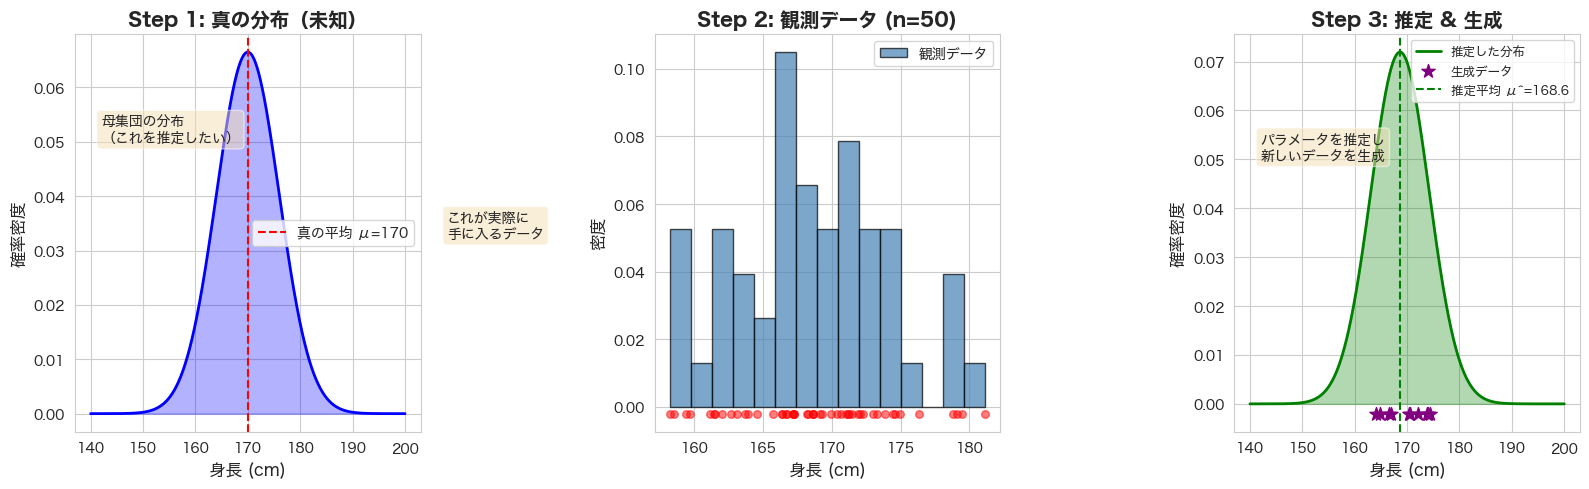

生成モデルの流れ
真のパラメータ（未知）: μ=170, σ=6
推定したパラメータ: μ̂=168.65, σ̂=5.55

生成した新しいデータ: [170.4 166.5 164.9 172.  174.4 173.8 164.  166.9 170.5 174.1]


In [2]:
# ============================================================
# 生成モデルの概念図
# データ生成 → パラメータ推定 → 新しいデータ生成 の流れを可視化
# ============================================================

np.random.seed(42)

# 真のパラメータ（通常は未知）
true_mu = 170
true_sigma = 6

# データをサンプリング（観測データ）
n_samples = 50
observed_data = np.random.normal(true_mu, true_sigma, n_samples)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. 真の分布（通常は未知）
x = np.linspace(140, 200, 1000)
true_pdf = stats.norm.pdf(x, true_mu, true_sigma)
axes[0].plot(x, true_pdf, 'b-', linewidth=2)
axes[0].fill_between(x, true_pdf, alpha=0.3, color='blue')
axes[0].axvline(x=true_mu, color='red', linestyle='--', label=f'真の平均 μ={true_mu}')
axes[0].set_xlabel('身長 (cm)', fontsize=12)
axes[0].set_ylabel('確率密度', fontsize=12)
axes[0].set_title('Step 1: 真の分布（未知）', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].text(142, 0.05, '母集団の分布\n（これを推定したい）', fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. 観測データ
axes[1].hist(observed_data, bins=15, density=True, alpha=0.7, color='steelblue', 
             edgecolor='black', label='観測データ')
# 観測データの点も表示
axes[1].scatter(observed_data, np.zeros_like(observed_data) - 0.002, 
                color='red', alpha=0.5, s=30, zorder=5)
axes[1].set_xlabel('身長 (cm)', fontsize=12)
axes[1].set_ylabel('密度', fontsize=12)
axes[1].set_title(f'Step 2: 観測データ (n={n_samples})', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].text(142, 0.05, 'これが実際に\n手に入るデータ', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 3. 推定した分布と生成データ
# 最尤推定（後で詳しく説明）
estimated_mu = np.mean(observed_data)
estimated_sigma = np.std(observed_data, ddof=0)  # MLEでは ddof=0

estimated_pdf = stats.norm.pdf(x, estimated_mu, estimated_sigma)
axes[2].plot(x, estimated_pdf, 'g-', linewidth=2, label='推定した分布')
axes[2].fill_between(x, estimated_pdf, alpha=0.3, color='green')

# 推定した分布から新しいデータを生成
generated_data = np.random.normal(estimated_mu, estimated_sigma, 10)
axes[2].scatter(generated_data, np.zeros_like(generated_data) - 0.002, 
                color='purple', s=100, marker='*', zorder=5, label='生成データ')

axes[2].axvline(x=estimated_mu, color='green', linestyle='--', 
                label=f'推定平均 μ̂={estimated_mu:.1f}')
axes[2].set_xlabel('身長 (cm)', fontsize=12)
axes[2].set_ylabel('確率密度', fontsize=12)
axes[2].set_title('Step 3: 推定 & 生成', fontsize=14, fontweight='bold')
axes[2].legend(fontsize=9)
axes[2].text(142, 0.05, 'パラメータを推定し\n新しいデータを生成', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("="*60)
print("生成モデルの流れ")
print("="*60)
print(f"真のパラメータ（未知）: μ={true_mu}, σ={true_sigma}")
print(f"推定したパラメータ: μ̂={estimated_mu:.2f}, σ̂={estimated_sigma:.2f}")
print(f"\n生成した新しいデータ: {generated_data.round(1)}")

### 📊 母集団とサンプル

統計学では、**母集団（Population）**と**サンプル（Sample）**を区別します：

| 概念 | 説明 | 例 |
|------|------|----|
| **母集団** | 調べたい対象全体 | 日本人全員の身長 |
| **サンプル** | 母集団から取り出した一部 | 100人分の身長データ |
| **母数（パラメータ）** | 母集団を特徴づける真の値 | 日本人の平均身長 μ |
| **統計量** | サンプルから計算した値 | サンプルの平均 x̄ |

```
母集団（未知）         サンプル（観測可能）
┌─────────────┐       ┌─────────┐
│  ●●●●●●●●●● │       │  ●●●    │
│  ●●●●●●●●●● │  ───→ │  ●●     │  抽出
│  ●●●●●●●●●● │       │  ●●●    │
│  ●●●●●●●●●● │       └─────────┘
│     ...     │             │
└─────────────┘             ↓
    真の分布            統計量を計算
    p(x; θ)            → θを推定
```

私たちの目標は、**サンプルから母集団のパラメータ（母数）を推定する**ことです。

---

## 2. 尤度関数

### 🤔 尤度とは？

**尤度（Likelihood）** は、あるパラメータの下でデータが観測される「もっともらしさ」を表します。

確率密度関数 $p(x|\theta)$ を考えます：

- **確率**として見る場合: パラメータ $\theta$ を固定して、$x$ の関数として見る
- **尤度**として見る場合: データ $x$ を固定して、$\theta$ の関数として見る

**尤度関数（Likelihood Function）**:

$$L(\theta) = L(\theta | x_1, x_2, ..., x_n) = \prod_{i=1}^{n} p(x_i | \theta)$$

つまり、各データ点の確率密度の積です。

### 🤔 なぜ積なのか？

データが**独立に同一の分布（i.i.d.）**から生成されたと仮定すると、同時確率は各確率の積になります：

$$P(x_1 \cap x_2 \cap ... \cap x_n) = P(x_1) \times P(x_2) \times ... \times P(x_n)$$

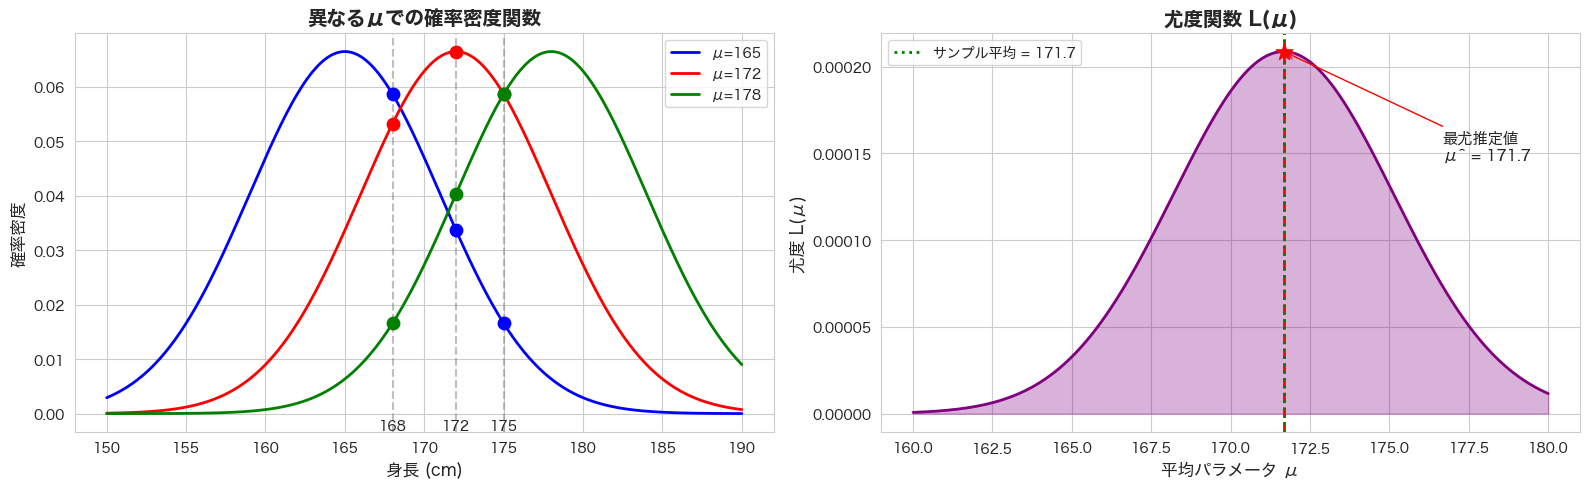

尤度の計算例
観測データ: [168 172 175]
サンプル平均: 171.67

各μでの尤度:
  μ=165: L = 3.275226e-05
  μ=172: L = 2.077207e-04
  μ=178: L = 3.923337e-05

最尤推定値 μ̂ = 171.67


In [3]:
# ============================================================
# 尤度関数の可視化
# 観測データが与えられたとき、異なるパラメータでの尤度を比較します
# ============================================================

np.random.seed(42)

# 観測データ（3点のみで説明）
observed = np.array([168, 172, 175])

# 異なる平均パラメータでの尤度を計算
def compute_likelihood(data, mu, sigma=6):
    """
    正規分布の尤度を計算
    
    Parameters:
    -----------
    data : array
        観測データ
    mu : float
        平均パラメータ
    sigma : float
        標準偏差（固定）
    
    Returns:
    --------
    float
        尤度（確率密度の積）
    """
    # 各データ点での確率密度を計算
    pdf_values = stats.norm.pdf(data, mu, sigma)
    # 積を返す
    return np.prod(pdf_values)

# 異なるμでの尤度
mu_range = np.linspace(160, 180, 1000)
likelihoods = [compute_likelihood(observed, mu) for mu in mu_range]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# 左: 各μでの確率密度関数とデータ点
x = np.linspace(150, 190, 500)
colors = ['blue', 'red', 'green']
mus = [165, 172, 178]

for mu, color in zip(mus, colors):
    pdf = stats.norm.pdf(x, mu, 6)
    axes[0].plot(x, pdf, color=color, linewidth=2, label=f'μ={mu}')
    
    # データ点での確率密度を計算して表示
    for d in observed:
        y_val = stats.norm.pdf(d, mu, 6)
        axes[0].scatter([d], [y_val], color=color, s=80, zorder=5)

# 観測データを縦線で表示
for d in observed:
    axes[0].axvline(x=d, color='gray', linestyle='--', alpha=0.5)
    axes[0].text(d, -0.003, f'{d}', ha='center', fontsize=10)

axes[0].set_xlabel('身長 (cm)', fontsize=12)
axes[0].set_ylabel('確率密度', fontsize=12)
axes[0].set_title('異なるμでの確率密度関数', fontsize=14, fontweight='bold')
axes[0].legend()

# 右: 尤度関数
axes[1].plot(mu_range, likelihoods, 'purple', linewidth=2)
axes[1].fill_between(mu_range, likelihoods, alpha=0.3, color='purple')

# 最尤推定値をマーク
max_idx = np.argmax(likelihoods)
mle_mu = mu_range[max_idx]
max_likelihood = likelihoods[max_idx]

axes[1].axvline(x=mle_mu, color='red', linestyle='--', linewidth=2)
axes[1].scatter([mle_mu], [max_likelihood], color='red', s=150, zorder=5, marker='*')
axes[1].annotate(f'最尤推定値\nμ̂ = {mle_mu:.1f}', 
                 xy=(mle_mu, max_likelihood), 
                 xytext=(mle_mu+5, max_likelihood*0.7),
                 fontsize=11,
                 arrowprops=dict(arrowstyle='->', color='red'))

# サンプル平均も表示
sample_mean = np.mean(observed)
axes[1].axvline(x=sample_mean, color='green', linestyle=':', linewidth=2, 
                label=f'サンプル平均 = {sample_mean:.1f}')

axes[1].set_xlabel('平均パラメータ μ', fontsize=12)
axes[1].set_ylabel('尤度 L(μ)', fontsize=12)
axes[1].set_title('尤度関数 L(μ)', fontsize=14, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

print("="*60)
print("尤度の計算例")
print("="*60)
print(f"観測データ: {observed}")
print(f"サンプル平均: {sample_mean:.2f}")
print(f"\n各μでの尤度:")
for mu in mus:
    L = compute_likelihood(observed, mu)
    print(f"  μ={mu}: L = {L:.6e}")
print(f"\n最尤推定値 μ̂ = {mle_mu:.2f}")

---

## 3. 最尤推定（Maximum Likelihood Estimation）

### 📊 最尤推定の考え方

**最尤推定**は、尤度関数を最大化するパラメータ $\hat{\theta}$ を求める方法です：

$$\hat{\theta}_{MLE} = \arg\max_{\theta} L(\theta) = \arg\max_{\theta} \prod_{i=1}^{n} p(x_i | \theta)$$

直感的には、「観測データが最も起こりやすいパラメータを選ぶ」ということです。

### 📊 対数尤度

実際には、積よりも和の方が扱いやすいため、**対数尤度（Log-Likelihood）**を最大化します：

$$\ell(\theta) = \log L(\theta) = \sum_{i=1}^{n} \log p(x_i | \theta)$$

対数は単調増加関数なので、尤度を最大化するパラメータと対数尤度を最大化するパラメータは同じです。

対数を取る利点：
1. 積が和になり、微分が簡単
2. 数値的に安定（アンダーフローを防ぐ）
3. 確率の積が非常に小さくなる問題を回避

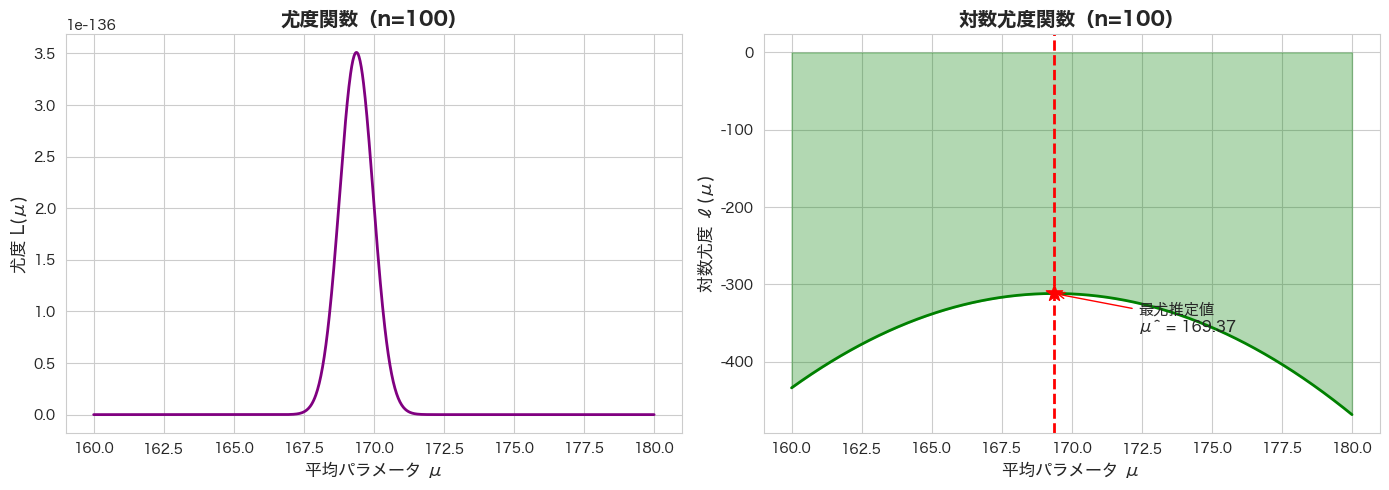

尤度 vs 対数尤度
データ数: n = 100
サンプル平均: 169.3769
最尤推定値: μ̂ = 169.3694

尤度の最大値: 3.51e-136  ← 非常に小さい！
対数尤度の最大値: -311.90


In [4]:
# ============================================================
# 対数尤度の可視化
# 尤度と対数尤度の関係を確認します
# ============================================================

def compute_log_likelihood(data, mu, sigma=6):
    """
    対数尤度を計算
    
    対数尤度 = Σ log p(x_i | μ, σ)
    """
    log_pdf_values = stats.norm.logpdf(data, mu, sigma)
    return np.sum(log_pdf_values)

# より多くのデータ点で計算
np.random.seed(42)
observed_large = np.random.normal(170, 6, 100)

mu_range = np.linspace(160, 180, 1000)

# 尤度と対数尤度を計算
likelihoods_large = [compute_likelihood(observed_large, mu) for mu in mu_range]
log_likelihoods = [compute_log_likelihood(observed_large, mu) for mu in mu_range]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左: 尤度（非常に小さい値になる）
axes[0].plot(mu_range, likelihoods_large, 'purple', linewidth=2)
axes[0].set_xlabel('平均パラメータ μ', fontsize=12)
axes[0].set_ylabel('尤度 L(μ)', fontsize=12)
axes[0].set_title('尤度関数（n=100）', fontsize=14, fontweight='bold')
axes[0].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# 右: 対数尤度
axes[1].plot(mu_range, log_likelihoods, 'green', linewidth=2)
axes[1].fill_between(mu_range, log_likelihoods, alpha=0.3, color='green')

# 最尤推定値
max_idx = np.argmax(log_likelihoods)
mle_mu = mu_range[max_idx]
max_ll = log_likelihoods[max_idx]

axes[1].axvline(x=mle_mu, color='red', linestyle='--', linewidth=2)
axes[1].scatter([mle_mu], [max_ll], color='red', s=150, zorder=5, marker='*')
axes[1].annotate(f'最尤推定値\nμ̂ = {mle_mu:.2f}', 
                 xy=(mle_mu, max_ll), 
                 xytext=(mle_mu+3, max_ll-50),
                 fontsize=11,
                 arrowprops=dict(arrowstyle='->', color='red'))

axes[1].set_xlabel('平均パラメータ μ', fontsize=12)
axes[1].set_ylabel('対数尤度 ℓ(μ)', fontsize=12)
axes[1].set_title('対数尤度関数（n=100）', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("="*60)
print("尤度 vs 対数尤度")
print("="*60)
print(f"データ数: n = {len(observed_large)}")
print(f"サンプル平均: {np.mean(observed_large):.4f}")
print(f"最尤推定値: μ̂ = {mle_mu:.4f}")
print(f"\n尤度の最大値: {max(likelihoods_large):.2e}  ← 非常に小さい！")
print(f"対数尤度の最大値: {max_ll:.2f}")

---

## 4. 正規分布の最尤推定

### 📊 解析的な導出

正規分布 $\mathcal{N}(\mu, \sigma^2)$ の対数尤度は：

$$\ell(\mu, \sigma^2) = -\frac{n}{2}\log(2\pi) - \frac{n}{2}\log(\sigma^2) - \frac{1}{2\sigma^2}\sum_{i=1}^n (x_i - \mu)^2$$

### 平均 μ の最尤推定

$\mu$ で微分して0とおくと：

$$\frac{\partial \ell}{\partial \mu} = \frac{1}{\sigma^2}\sum_{i=1}^n (x_i - \mu) = 0$$

$$\sum_{i=1}^n x_i - n\mu = 0$$

$$\hat{\mu}_{MLE} = \frac{1}{n}\sum_{i=1}^n x_i = \bar{x}$$

つまり、**平均の最尤推定量はサンプル平均**です！

### 分散 σ² の最尤推定

同様に $\sigma^2$ で微分すると：

$$\hat{\sigma}^2_{MLE} = \frac{1}{n}\sum_{i=1}^n (x_i - \bar{x})^2$$

これは**標本分散**（ただし不偏分散ではなく、nで割る版）です。

In [5]:
# ============================================================
# 正規分布の最尤推定の実装
# 解析解と数値最適化の両方で確認します
# ============================================================

np.random.seed(42)

# 真のパラメータ
true_mu = 170
true_sigma = 6

# データを生成
n_samples = 100
data = np.random.normal(true_mu, true_sigma, n_samples)

# 解析解（サンプル平均とサンプル分散）
mu_mle_analytical = np.mean(data)
sigma2_mle_analytical = np.var(data, ddof=0)  # MLEはddof=0
sigma_mle_analytical = np.sqrt(sigma2_mle_analytical)

print("="*60)
print("正規分布の最尤推定")
print("="*60)
print(f"真のパラメータ: μ={true_mu}, σ={true_sigma}")
print(f"\n【解析解】")
print(f"  μ̂ = {mu_mle_analytical:.4f}")
print(f"  σ̂ = {sigma_mle_analytical:.4f}")

# 数値最適化で確認
def negative_log_likelihood(params, data):
    """
    負の対数尤度（最小化するため）
    
    Parameters:
    -----------
    params : array
        [mu, log_sigma] - sigmaは正の値なのでlogをとる
    data : array
        観測データ
    """
    mu, log_sigma = params
    sigma = np.exp(log_sigma)  # 正の値を保証
    
    # 対数尤度
    n = len(data)
    ll = -n/2 * np.log(2*np.pi) - n * log_sigma - np.sum((data - mu)**2) / (2*sigma**2)
    
    return -ll  # 負を返す（最小化のため）

# 初期値
initial_params = [160, np.log(10)]  # [mu, log_sigma]

# 最適化
result = minimize(negative_log_likelihood, initial_params, args=(data,), method='BFGS')
mu_mle_numerical = result.x[0]
sigma_mle_numerical = np.exp(result.x[1])

print(f"\n【数値最適化】")
print(f"  μ̂ = {mu_mle_numerical:.4f}")
print(f"  σ̂ = {sigma_mle_numerical:.4f}")

print(f"\n→ 解析解と数値解が一致していることを確認！")

正規分布の最尤推定
真のパラメータ: μ=170, σ=6

【解析解】
  μ̂ = 169.3769
  σ̂ = 5.4217

【数値最適化】
  μ̂ = 169.3769
  σ̂ = 5.4217

→ 解析解と数値解が一致していることを確認！


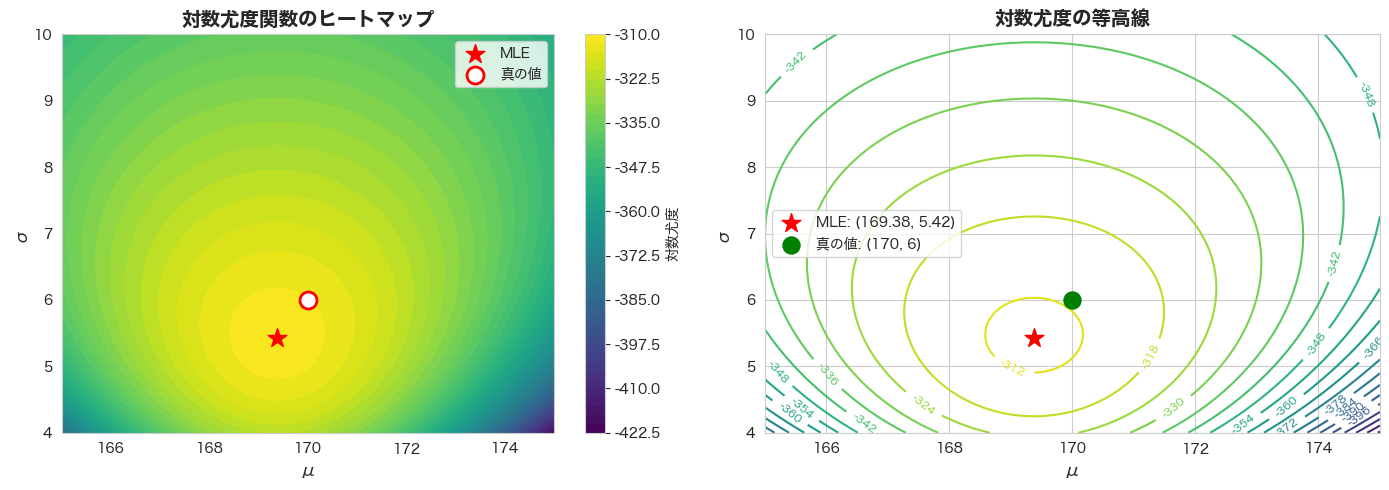

💡 ポイント: 対数尤度が最大になる点（★）がMLEです
   サンプルサイズを増やすと、MLEは真の値に近づきます


In [6]:
# ============================================================
# 2次元での対数尤度の可視化
# μとσを同時に変化させたときの対数尤度をヒートマップで表示
# ============================================================

# パラメータの範囲
mu_grid = np.linspace(165, 175, 100)
sigma_grid = np.linspace(4, 10, 100)

# 対数尤度を計算
log_likelihood_grid = np.zeros((len(sigma_grid), len(mu_grid)))

for i, sigma in enumerate(sigma_grid):
    for j, mu in enumerate(mu_grid):
        log_likelihood_grid[i, j] = np.sum(stats.norm.logpdf(data, mu, sigma))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左: ヒートマップ
im = axes[0].contourf(mu_grid, sigma_grid, log_likelihood_grid, levels=50, cmap='viridis')
axes[0].scatter([mu_mle_analytical], [sigma_mle_analytical], color='red', s=200, 
                marker='*', zorder=5, label='MLE')
axes[0].scatter([true_mu], [true_sigma], color='white', s=150, 
                marker='o', edgecolors='red', linewidths=2, zorder=5, label='真の値')
axes[0].set_xlabel('μ', fontsize=12)
axes[0].set_ylabel('σ', fontsize=12)
axes[0].set_title('対数尤度関数のヒートマップ', fontsize=14, fontweight='bold')
axes[0].legend()
plt.colorbar(im, ax=axes[0], label='対数尤度')

# 右: 等高線プロット
contour = axes[1].contour(mu_grid, sigma_grid, log_likelihood_grid, levels=20, cmap='viridis')
axes[1].clabel(contour, inline=True, fontsize=8)
axes[1].scatter([mu_mle_analytical], [sigma_mle_analytical], color='red', s=200, 
                marker='*', zorder=5, label=f'MLE: ({mu_mle_analytical:.2f}, {sigma_mle_analytical:.2f})')
axes[1].scatter([true_mu], [true_sigma], color='green', s=150, 
                marker='o', zorder=5, label=f'真の値: ({true_mu}, {true_sigma})')
axes[1].set_xlabel('μ', fontsize=12)
axes[1].set_ylabel('σ', fontsize=12)
axes[1].set_title('対数尤度の等高線', fontsize=14, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

print("💡 ポイント: 対数尤度が最大になる点（★）がMLEです")
print("   サンプルサイズを増やすと、MLEは真の値に近づきます")

---

## 5. サンプルサイズと推定精度

### 🤔 大数の法則と一致性

最尤推定量は**一致性（Consistency）**を持ちます：

> サンプルサイズ n が増加すると、最尤推定量は真のパラメータに確率収束する

$$\hat{\theta}_{MLE} \xrightarrow{p} \theta \quad (n \to \infty)$$

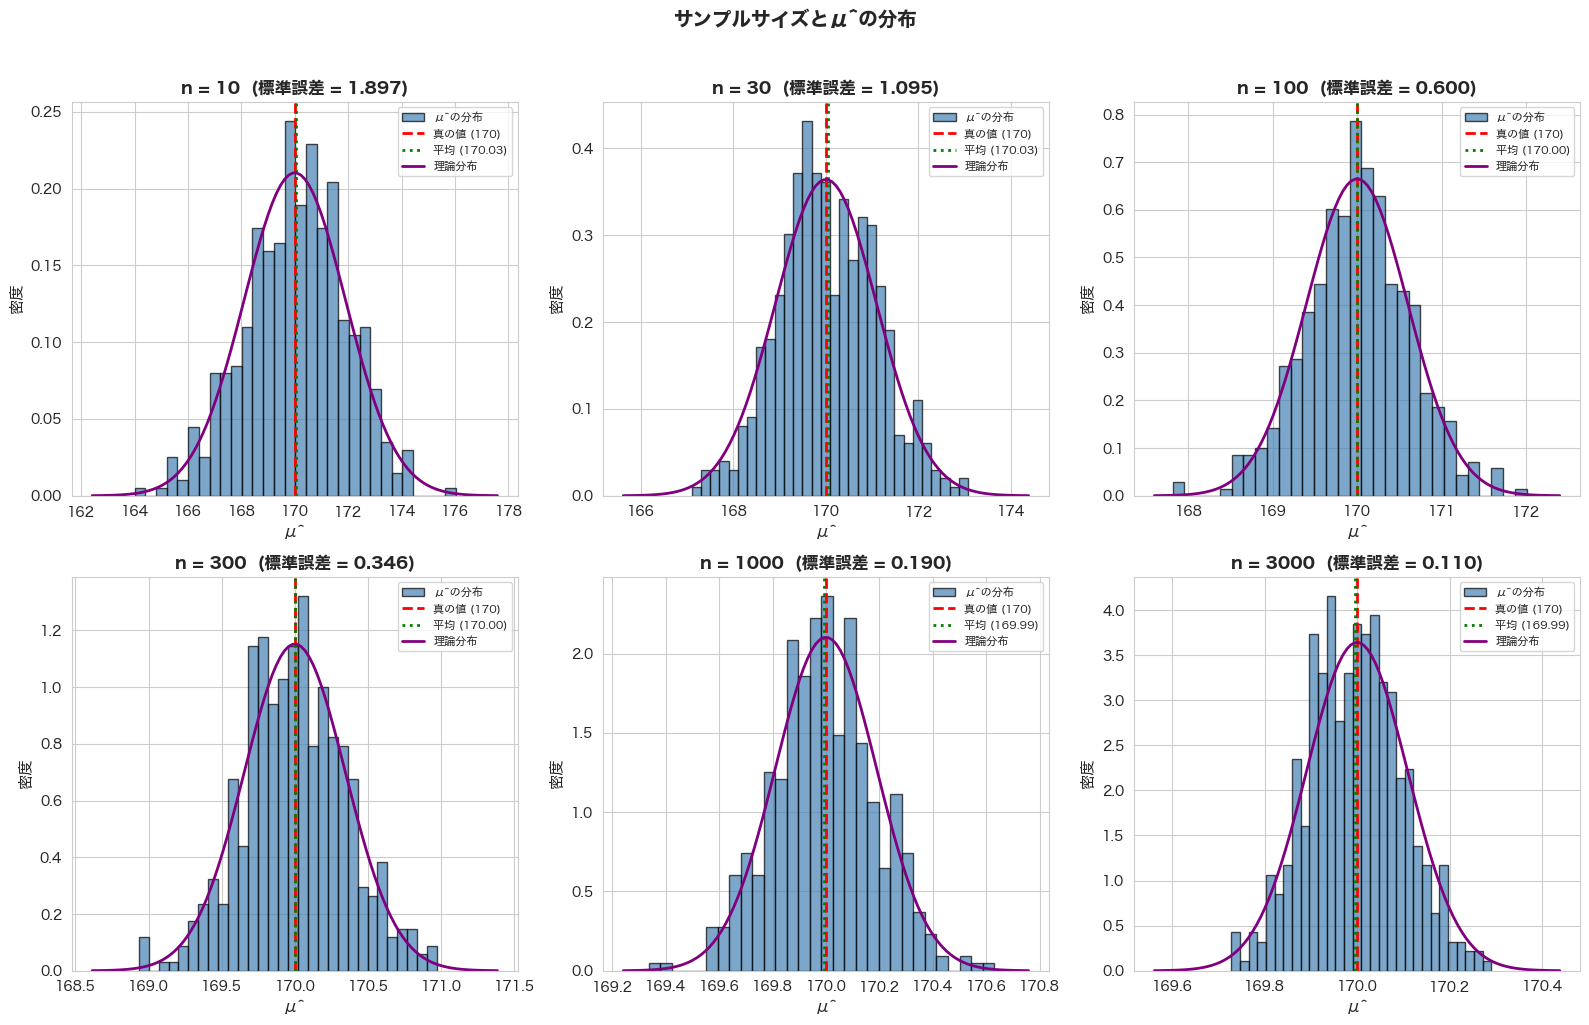

💡 ポイント:
  - サンプルサイズnが増えると、推定値のばらつきが小さくなる
  - 標準誤差 = σ/√n なので、nを4倍にすると標準誤差は半分になる
  - MLEは真の値の周りに集中していく（一致性）


In [7]:
# ============================================================
# サンプルサイズと推定精度の関係
# nを増やすとMLEが真の値に近づくことを確認します
# ============================================================

np.random.seed(42)

true_mu = 170
true_sigma = 6

# 異なるサンプルサイズ
sample_sizes = [10, 30, 100, 300, 1000, 3000]
n_experiments = 500  # 各サンプルサイズでの実験回数

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for ax, n in zip(axes, sample_sizes):
    # n個のサンプルからMLEを計算することをn_experiments回繰り返す
    mu_estimates = []
    sigma_estimates = []
    
    for _ in range(n_experiments):
        samples = np.random.normal(true_mu, true_sigma, n)
        mu_estimates.append(np.mean(samples))
        sigma_estimates.append(np.std(samples, ddof=0))
    
    # μの推定値の分布
    ax.hist(mu_estimates, bins=30, density=True, alpha=0.7, color='steelblue', 
            edgecolor='black', label='μ̂の分布')
    ax.axvline(x=true_mu, color='red', linestyle='--', linewidth=2, label=f'真の値 ({true_mu})')
    ax.axvline(x=np.mean(mu_estimates), color='green', linestyle=':', linewidth=2, 
               label=f'平均 ({np.mean(mu_estimates):.2f})')
    
    # 理論的な分布（標準誤差 = σ/√n）
    theoretical_se = true_sigma / np.sqrt(n)
    x_range = np.linspace(true_mu - 4*theoretical_se, true_mu + 4*theoretical_se, 100)
    theoretical_pdf = stats.norm.pdf(x_range, true_mu, theoretical_se)
    ax.plot(x_range, theoretical_pdf, 'purple', linewidth=2, label='理論分布')
    
    ax.set_xlabel('μ̂', fontsize=11)
    ax.set_ylabel('密度', fontsize=11)
    ax.set_title(f'n = {n}  (標準誤差 = {theoretical_se:.3f})', fontsize=12, fontweight='bold')
    ax.legend(fontsize=8)

plt.suptitle('サンプルサイズとμ̂の分布', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("💡 ポイント:")
print("  - サンプルサイズnが増えると、推定値のばらつきが小さくなる")
print("  - 標準誤差 = σ/√n なので、nを4倍にすると標準誤差は半分になる")
print("  - MLEは真の値の周りに集中していく（一致性）")

---

## 6. 生成モデルとしての利用

### 📊 パラメータ推定から生成へ

最尤推定で得たパラメータを使って、**新しいデータを生成**できます。

これが「生成モデル」の基本的なアイデアです：

1. データから分布のパラメータを推定
2. 推定した分布からサンプリング
3. 「本物らしい」新しいデータが得られる

モデルを学習しました: μ̂=170.76, σ̂=5.57


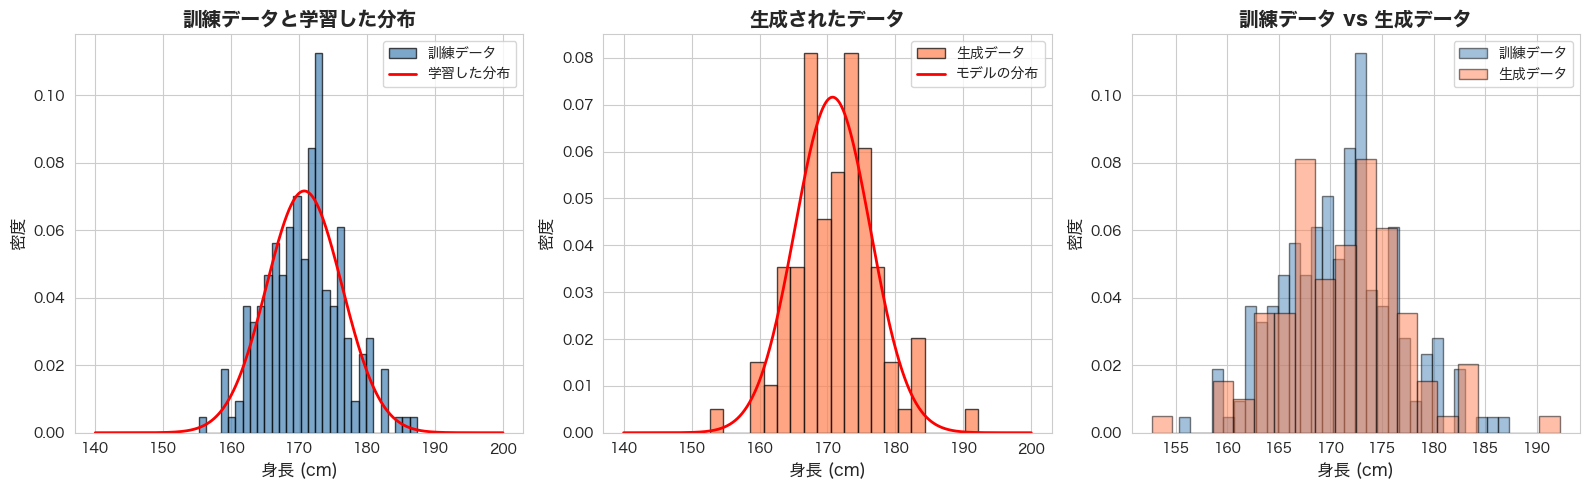


生成データの統計量
訓練データ: 平均=170.76, 標準偏差=5.57
生成データ: 平均=171.12, 標準偏差=6.01

生成された身長の例: [172.7 173.9 176.8 176.6 163.1 165.5 173.6 173.6 173.6 192.2]


In [8]:
# ============================================================
# 生成モデルの実装
# 身長データを正規分布でモデル化し、新しい身長データを生成します
# ============================================================

np.random.seed(42)

class SimpleGenerativeModel:
    """
    正規分布による単純な生成モデル
    
    このモデルは:
    1. データから最尤推定でパラメータを学習
    2. 学習した分布から新しいデータを生成
    """
    
    def __init__(self):
        self.mu = None
        self.sigma = None
        self.is_fitted = False
    
    def fit(self, data):
        """
        データから最尤推定でパラメータを学習
        
        Parameters:
        -----------
        data : array-like
            訓練データ
        """
        self.mu = np.mean(data)
        self.sigma = np.std(data, ddof=0)  # MLE
        self.is_fitted = True
        print(f"モデルを学習しました: μ̂={self.mu:.2f}, σ̂={self.sigma:.2f}")
        return self
    
    def generate(self, n_samples):
        """
        新しいデータを生成
        
        Parameters:
        -----------
        n_samples : int
            生成するサンプル数
        
        Returns:
        --------
        array
            生成されたサンプル
        """
        if not self.is_fitted:
            raise ValueError("モデルが学習されていません。先にfit()を呼んでください。")
        
        return np.random.normal(self.mu, self.sigma, n_samples)
    
    def log_likelihood(self, data):
        """
        データの対数尤度を計算
        
        高い値 = データがこのモデルから生成された可能性が高い
        """
        if not self.is_fitted:
            raise ValueError("モデルが学習されていません")
        
        return np.sum(stats.norm.logpdf(data, self.mu, self.sigma))

# 訓練データを作成（実際のデータを想定）
true_mu = 171
true_sigma = 6
training_data = np.random.normal(true_mu, true_sigma, 200)

# モデルを学習
model = SimpleGenerativeModel()
model.fit(training_data)

# 新しいデータを生成
generated_samples = model.generate(100)

# 可視化
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 左: 訓練データ
axes[0].hist(training_data, bins=30, density=True, alpha=0.7, color='steelblue', 
             edgecolor='black', label='訓練データ')
x = np.linspace(140, 200, 1000)
axes[0].plot(x, stats.norm.pdf(x, model.mu, model.sigma), 'r-', linewidth=2, 
             label='学習した分布')
axes[0].set_xlabel('身長 (cm)', fontsize=12)
axes[0].set_ylabel('密度', fontsize=12)
axes[0].set_title('訓練データと学習した分布', fontsize=14, fontweight='bold')
axes[0].legend()

# 中央: 生成データ
axes[1].hist(generated_samples, bins=20, density=True, alpha=0.7, color='coral', 
             edgecolor='black', label='生成データ')
axes[1].plot(x, stats.norm.pdf(x, model.mu, model.sigma), 'r-', linewidth=2, 
             label='モデルの分布')
axes[1].set_xlabel('身長 (cm)', fontsize=12)
axes[1].set_ylabel('密度', fontsize=12)
axes[1].set_title('生成されたデータ', fontsize=14, fontweight='bold')
axes[1].legend()

# 右: 比較
axes[2].hist(training_data, bins=30, density=True, alpha=0.5, color='steelblue', 
             edgecolor='black', label='訓練データ')
axes[2].hist(generated_samples, bins=20, density=True, alpha=0.5, color='coral', 
             edgecolor='black', label='生成データ')
axes[2].set_xlabel('身長 (cm)', fontsize=12)
axes[2].set_ylabel('密度', fontsize=12)
axes[2].set_title('訓練データ vs 生成データ', fontsize=14, fontweight='bold')
axes[2].legend()

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("生成データの統計量")
print("="*60)
print(f"訓練データ: 平均={np.mean(training_data):.2f}, 標準偏差={np.std(training_data):.2f}")
print(f"生成データ: 平均={np.mean(generated_samples):.2f}, 標準偏差={np.std(generated_samples):.2f}")
print(f"\n生成された身長の例: {generated_samples[:10].round(1)}")

---

## 7. 生成モデルの応用: 異常検知

### 🤔 異常検知とは？

生成モデルは**異常検知（Anomaly Detection）**にも使えます：

1. 正常なデータで分布を学習
2. 新しいデータの確率（尤度）を計算
3. 確率が低いデータを「異常」と判定

これは、「学習した分布からは生成されにくいデータ」を検出する方法です。

モデルを学習しました: μ̂=170.76, σ̂=5.57


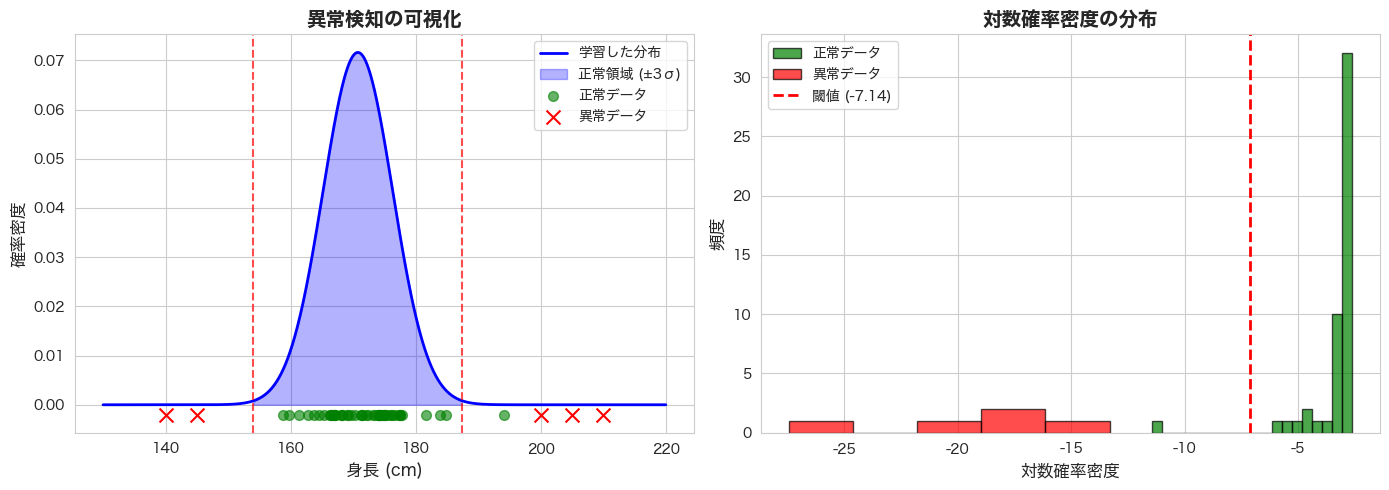

異常検知の結果

閾値: log p(x) < -7.1367 を異常と判定

異常データの対数確率密度:
  身長 140cm: log p = -17.8696 → 異常検出
  身長 145cm: log p = -13.3193 → 異常検出
  身長 200cm: log p = -16.4099 → 異常検出
  身長 205cm: log p = -21.5221 → 異常検出
  身長 210cm: log p = -27.4396 → 異常検出

正解率: 98.2%


In [9]:
# ============================================================
# 生成モデルによる異常検知
# 身長データで異常に高い/低い値を検出します
# ============================================================

np.random.seed(42)

# 正常データで学習
normal_heights = np.random.normal(171, 6, 200)
model = SimpleGenerativeModel()
model.fit(normal_heights)

# テストデータ（一部に異常値を含む）
test_normal = np.random.normal(171, 6, 50)
test_anomalies = np.array([140, 145, 200, 205, 210])  # 異常値
test_data = np.concatenate([test_normal, test_anomalies])
labels = np.array([0]*50 + [1]*5)  # 0=正常, 1=異常

# 各データ点の対数確率密度を計算
log_probs = stats.norm.logpdf(test_data, model.mu, model.sigma)

# 閾値を設定（例：-3σより外側を異常とする）
threshold = stats.norm.logpdf(model.mu - 3*model.sigma, model.mu, model.sigma)

# 異常判定
predictions = (log_probs < threshold).astype(int)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左: データと分布
x = np.linspace(130, 220, 1000)
pdf = stats.norm.pdf(x, model.mu, model.sigma)
axes[0].plot(x, pdf, 'b-', linewidth=2, label='学習した分布')
axes[0].fill_between(x, pdf, where=(x >= model.mu - 3*model.sigma) & (x <= model.mu + 3*model.sigma),
                     alpha=0.3, color='blue', label='正常領域 (±3σ)')

# 正常データ
axes[0].scatter(test_data[labels==0], np.zeros_like(test_data[labels==0]) - 0.002, 
                color='green', s=50, alpha=0.6, label='正常データ')
# 異常データ
axes[0].scatter(test_data[labels==1], np.zeros_like(test_data[labels==1]) - 0.002, 
                color='red', s=100, marker='x', label='異常データ')

axes[0].axvline(x=model.mu - 3*model.sigma, color='red', linestyle='--', alpha=0.7)
axes[0].axvline(x=model.mu + 3*model.sigma, color='red', linestyle='--', alpha=0.7)
axes[0].set_xlabel('身長 (cm)', fontsize=12)
axes[0].set_ylabel('確率密度', fontsize=12)
axes[0].set_title('異常検知の可視化', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)

# 右: 対数確率密度のヒストグラム
axes[1].hist(log_probs[labels==0], bins=20, alpha=0.7, color='green', 
             edgecolor='black', label='正常データ')
axes[1].hist(log_probs[labels==1], bins=5, alpha=0.7, color='red', 
             edgecolor='black', label='異常データ')
axes[1].axvline(x=threshold, color='red', linestyle='--', linewidth=2, 
                label=f'閾値 ({threshold:.2f})')
axes[1].set_xlabel('対数確率密度', fontsize=12)
axes[1].set_ylabel('頻度', fontsize=12)
axes[1].set_title('対数確率密度の分布', fontsize=14, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

# 性能評価
print("="*60)
print("異常検知の結果")
print("="*60)
print(f"\n閾値: log p(x) < {threshold:.4f} を異常と判定")
print(f"\n異常データの対数確率密度:")
for val, lp in zip(test_anomalies, log_probs[-5:]):
    status = "異常検出" if lp < threshold else "正常と判定"
    print(f"  身長 {val}cm: log p = {lp:.4f} → {status}")

# 混同行列
from sklearn.metrics import confusion_matrix, classification_report
print(f"\n正解率: {np.mean(predictions == labels)*100:.1f}%")

---

## 8. 複数のモデルの比較

### 🤔 モデル選択

データに対して複数のモデルを当てはめて、どちらが良いかを比較できます。
対数尤度が高いモデルの方が、データをよく説明しています。

ただし、パラメータ数が異なる場合は、**AIC（赤池情報量規準）**や**BIC（ベイズ情報量規準）**を使います：

$$AIC = -2\ell(\hat{\theta}) + 2k$$
$$BIC = -2\ell(\hat{\theta}) + k \log n$$

ここで $k$ はパラメータ数、$n$ はサンプルサイズです。値が小さいほど良いモデルです。


データ: 正規分布から生成

正規分布: N(169.38, 5.42²)
  対数尤度: -310.93

一様分布: U(154.28, 181.11)
  対数尤度: -328.96

→ 正規分布 の方が適合が良い

データ: 一様分布から生成

正規分布: N(169.59, 8.60²)
  対数尤度: -357.08

一様分布: U(155.15, 184.57)
  対数尤度: -338.16

→ 一様分布 の方が適合が良い


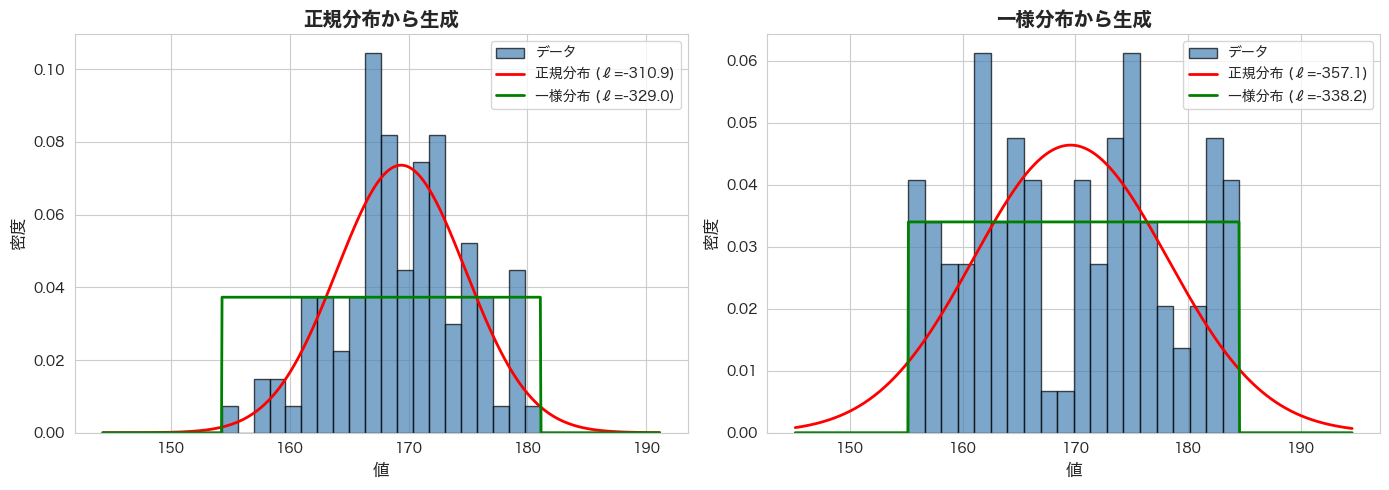

In [10]:
# ============================================================
# 異なる分布でのモデル比較
# 正規分布 vs 一様分布 でどちらがデータに適合するか比較
# ============================================================

np.random.seed(42)

# 正規分布から生成されたデータ
data_normal = np.random.normal(170, 6, 100)

# 一様分布から生成されたデータ
data_uniform = np.random.uniform(155, 185, 100)

def fit_and_evaluate(data, data_name):
    """
    データに正規分布と一様分布をフィットし、対数尤度を比較
    """
    print(f"\n{'='*60}")
    print(f"データ: {data_name}")
    print(f"{'='*60}")
    
    # 正規分布のMLE
    mu_mle = np.mean(data)
    sigma_mle = np.std(data, ddof=0)
    ll_normal = np.sum(stats.norm.logpdf(data, mu_mle, sigma_mle))
    
    # 一様分布のMLE
    a_mle = np.min(data)
    b_mle = np.max(data)
    ll_uniform = np.sum(stats.uniform.logpdf(data, a_mle, b_mle - a_mle))
    
    print(f"\n正規分布: N({mu_mle:.2f}, {sigma_mle:.2f}²)")
    print(f"  対数尤度: {ll_normal:.2f}")
    
    print(f"\n一様分布: U({a_mle:.2f}, {b_mle:.2f})")
    print(f"  対数尤度: {ll_uniform:.2f}")
    
    winner = "正規分布" if ll_normal > ll_uniform else "一様分布"
    print(f"\n→ {winner} の方が適合が良い")
    
    return mu_mle, sigma_mle, a_mle, b_mle, ll_normal, ll_uniform

# 正規分布から生成されたデータでの比較
params_normal = fit_and_evaluate(data_normal, "正規分布から生成")

# 一様分布から生成されたデータでの比較
params_uniform = fit_and_evaluate(data_uniform, "一様分布から生成")

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, data, title, params in zip(axes, 
                                    [data_normal, data_uniform],
                                    ['正規分布から生成', '一様分布から生成'],
                                    [params_normal, params_uniform]):
    mu, sigma, a, b, ll_n, ll_u = params
    
    # ヒストグラム
    ax.hist(data, bins=20, density=True, alpha=0.7, color='steelblue', 
            edgecolor='black', label='データ')
    
    # フィットした分布
    x = np.linspace(data.min()-10, data.max()+10, 1000)
    ax.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, 
            label=f'正規分布 (ℓ={ll_n:.1f})')
    ax.plot(x, stats.uniform.pdf(x, a, b-a), 'g-', linewidth=2, 
            label=f'一様分布 (ℓ={ll_u:.1f})')
    
    ax.set_xlabel('値', fontsize=12)
    ax.set_ylabel('密度', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend()

plt.tight_layout()
plt.show()

---

## まとめ

### 🎯 このノートブックで学んだこと

**生成モデルの概念**
- ✓ 生成モデルはデータの分布 P(x) をモデル化する
- ✓ 識別モデル（P(y|x)）とは目的が異なる
- ✓ 学習した分布から新しいデータを生成できる

**最尤推定**
- ✓ 尤度は「パラメータがデータを説明するもっともらしさ」
- ✓ 対数尤度を最大化するパラメータを求める
- ✓ 正規分布のMLEはサンプル平均とサンプル分散

**応用**
- ✓ 推定したパラメータで新しいデータを生成
- ✓ 尤度を使った異常検知
- ✓ モデル比較（対数尤度、AIC、BIC）

### 📊 最尤推定のチートシート

| 分布 | パラメータ | MLE |
|------|----------|-----|
| 正規分布 | μ | $\hat{\mu} = \bar{x} = \frac{1}{n}\sum x_i$ |
| 正規分布 | σ² | $\hat{\sigma}^2 = \frac{1}{n}\sum (x_i - \bar{x})^2$ |
| ベルヌーイ分布 | p | $\hat{p} = \frac{成功数}{n}$ |
| ポアソン分布 | λ | $\hat{\lambda} = \bar{x}$ |

### 🔧 実践的なワークフロー

```python
# 1. データを準備
data = load_data()

# 2. 最尤推定でパラメータを学習
mu_mle = np.mean(data)
sigma_mle = np.std(data, ddof=0)

# 3. 新しいデータを生成
generated = np.random.normal(mu_mle, sigma_mle, n_samples)

# 4. 対数尤度でモデルの良さを評価
log_likelihood = np.sum(stats.norm.logpdf(data, mu_mle, sigma_mle))
```

---

### ⚠️ よくあるエラー

#### エラー #1: 不偏分散とMLE分散の混同

```python
# ❌ 間違い: 不偏分散（ddof=1）をMLEとして使用
sigma_mle = np.std(data, ddof=1)  # これは不偏推定量

# ✅ 正しい: MLEはddof=0
sigma_mle = np.std(data, ddof=0)
```

注意: 実用上は不偏分散（ddof=1）を使うことが多いですが、
      厳密なMLEはddof=0です。

#### エラー #2: 尤度のアンダーフロー

```python
# ❌ 問題: 尤度の積は非常に小さくなる
likelihood = np.prod([stats.norm.pdf(x, mu, sigma) for x in data])
# → 0.0 になることがある（アンダーフロー）

# ✅ 正しい: 対数尤度を使う
log_likelihood = np.sum(stats.norm.logpdf(data, mu, sigma))
```

---

## 🎓 自己評価クイズ

### Q1: 最尤推定とは何ですか？一言で説明してください。

<details>
<summary>💡 答えを見る</summary>

**答え**: 観測データが最も起こりやすい（尤度が最大になる）パラメータを求める方法

直感的には、「このデータが生成される確率が最も高くなるようなパラメータは何か？」という問いに答える方法です。

</details>

---

### Q2: なぜ対数尤度を使うのですか？

<details>
<summary>💡 答えを見る</summary>

**答え**: 主に2つの理由があります

1. **計算の簡単化**: 積が和になり、微分が簡単になる
2. **数値的安定性**: 確率の積は非常に小さくなる（アンダーフロー）のを防ぐ

対数は単調増加関数なので、尤度を最大化するパラメータ = 対数尤度を最大化するパラメータです。

</details>

---

### Q3: 正規分布の平均の最尤推定量は何ですか？

<details>
<summary>💡 答えを見る</summary>

**答え**: サンプル平均 $\bar{x} = \frac{1}{n}\sum_{i=1}^n x_i$

これは直感的にも納得できます：データの平均値が、分布の中心（平均パラメータ）の最良の推定値です。

</details>

---

### Q4: 生成モデルを使った異常検知の基本的なアイデアは？

<details>
<summary>💡 答えを見る</summary>

**答え**: 学習した分布での確率（尤度）が低いデータを異常と判定する

正常なデータで分布を学習し、新しいデータがその分布から生成された可能性が低い場合、それは「異常」である可能性が高いという考え方です。

</details>

---

### Q5: 識別モデルと生成モデルの違いは何ですか？

<details>
<summary>💡 答えを見る</summary>

**答え**:

- **識別モデル**: P(y|x) をモデル化。入力xからラベルyを予測することが目的。
  例: ロジスティック回帰、SVM、多くのニューラルネット

- **生成モデル**: P(x) または P(x,y) をモデル化。データの分布を学習し、新しいデータを生成することが目的。
  例: GMM、VAE、GAN、拡散モデル

</details>

---

### 📚 練習問題

1. **ポアソン分布のMLE**: ポアソン分布 $P(X=k) = \frac{\lambda^k e^{-\lambda}}{k!}$ の λ の最尤推定量を導出してください。（ヒント: 対数尤度を λ で微分して0とおく）

2. **異なるサンプルサイズでの比較**: 同じ真のパラメータ（μ=100, σ=15）から、サンプルサイズ n=10, 50, 100, 500 でデータを生成し、それぞれのMLEのばらつきを比較してください。

3. **モデル選択の実験**: 正規分布から生成されたデータに対して、正規分布、一様分布、ラプラス分布をフィットし、AICで比較してください。

---

### ✅ 学習チェックリスト

- [ ] 生成モデルと識別モデルの違いを説明できる
- [ ] 尤度と対数尤度の関係を理解している
- [ ] 正規分布のMLEを導出できる
- [ ] Pythonで最尤推定を実装できる
- [ ] 生成モデルを使った異常検知の原理を説明できる

---

**次のステップ**: Notebook 32で、**多次元正規分布と共分散**を学びます！

1次元の正規分布を多次元に拡張し、変数間の相関を表現する**共分散行列**について学習します。これはVAEや拡散モデルの理解に不可欠な概念です。